In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm  # Use notebook version for Jupyter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import xgboost as xgb
from datetime import datetime

In [2]:
# Load BDT models
bdt_models = []
for i in range(12):
    filename = f"bdt_model_bg{i+1}_depth2_n100_lr0.1.joblib"
    filepath = os.path.join("models", filename)
    
    if os.path.exists(filepath):
        model = joblib.load(filepath)
        bdt_models.append(model)
        print(f"Loaded BDT Model {i+1} from {filepath}")
    else:
        print(f"Model {i+1} not found, you may need to train it first.")

# Load XGBoost models
xgb_models = []
for i in range(12):
    filename = f"xgb_model_bg{i+1}_depth2_n100_lr0.1.model"
    filepath = os.path.join("xgb_models", filename)
    
    if os.path.exists(filepath):
        model = xgb.Booster()
        model.load_model(filepath)
        xgb_models.append(model)
        print(f"Loaded XGBoost Model {i+1} from {filepath}")
    else:
        print(f"Model {i+1} not found, you may need to train it first.")

Loaded BDT Model 1 from models/bdt_model_bg1_depth2_n100_lr0.1.joblib
Loaded BDT Model 2 from models/bdt_model_bg2_depth2_n100_lr0.1.joblib
Loaded BDT Model 3 from models/bdt_model_bg3_depth2_n100_lr0.1.joblib
Loaded BDT Model 4 from models/bdt_model_bg4_depth2_n100_lr0.1.joblib
Loaded BDT Model 5 from models/bdt_model_bg5_depth2_n100_lr0.1.joblib
Loaded BDT Model 6 from models/bdt_model_bg6_depth2_n100_lr0.1.joblib
Loaded BDT Model 7 from models/bdt_model_bg7_depth2_n100_lr0.1.joblib
Loaded BDT Model 8 from models/bdt_model_bg8_depth2_n100_lr0.1.joblib
Loaded BDT Model 9 from models/bdt_model_bg9_depth2_n100_lr0.1.joblib
Loaded BDT Model 10 from models/bdt_model_bg10_depth2_n100_lr0.1.joblib
Loaded BDT Model 11 from models/bdt_model_bg11_depth2_n100_lr0.1.joblib
Loaded BDT Model 12 from models/bdt_model_bg12_depth2_n100_lr0.1.joblib
Loaded XGBoost Model 1 from xgb_models/xgb_model_bg1_depth2_n100_lr0.1.model
Loaded XGBoost Model 2 from xgb_models/xgb_model_bg2_depth2_n100_lr0.1.model


In [3]:
# Define dataset folder
raw_data_folder = "raw dataset"

# Get all CSV files
all_files = sorted([f for f in os.listdir(raw_data_folder) if f.endswith(".csv")])

# Identify signal and background files
signal_files = [f for f in all_files if "signal" in f.lower()]
background_files = sorted([f for f in all_files if "background" in f.lower() or "b" in f.lower()])

# Ensure files exist
if not signal_files:
    raise FileNotFoundError("No signal file found in the dataset directory.")
if not background_files:
    raise FileNotFoundError("No background files found in the dataset directory.")

# # Load and merge signal datasets
# signal_dfs = [pd.read_csv(os.path.join(raw_data_folder, sf)) for sf in signal_files]
# signal_df = pd.concat(signal_dfs, ignore_index=True)
# signal_df["label"] = 1  # Assign label 1 for signals

# # Load and merge background datasets
# background_dfs = []
background_labels = []

for idx, bg_file in enumerate(background_files):
    # bg_df = pd.read_csv(os.path.join(raw_data_folder, bg_file))
    # bg_df["label"] = 0  # Assign label 0 for backgrounds
    # background_dfs.append(bg_df)
    background_labels.append(bg_file)
    print(f"Loaded Background {idx+1}: {bg_file}")

# Extract feature columns (EXCLUDE "label")
# feature_columns = [col for col in signal_df.columns if col != "label"]

# X_signal = signal_df[feature_columns].copy()
# y_signal = signal_df["label"].copy()

# X_backgrounds = [bg[feature_columns].copy() for bg in background_dfs]
# y_backgrounds = [bg["label"].copy() for bg in background_dfs]

Loaded Background 1: BWW.csv
Loaded Background 2: BZH.csv
Loaded Background 3: BZZ.csv
Loaded Background 4: Bpebb.csv
Loaded Background 5: Bpebbqq.csv
Loaded Background 6: BpeqqH.csv
Loaded Background 7: Bpett.csv
Loaded Background 8: Bqq.csv
Loaded Background 9: BqqHX.csv
Loaded Background 10: BqqX.csv
Loaded Background 11: BqqqqX.csv
Loaded Background 12: Btt.csv


In [4]:
# # Split signal dataset
# X_signal_train, X_signal_test, y_signal_train, y_signal_test = train_test_split(X_signal, y_signal, test_size=0.25, random_state=42)

# # Split each background dataset
# X_backgrounds_train = []
# X_backgrounds_test = []
# y_backgrounds_train = []
# y_backgrounds_test = []

# for X_bg, y_bg in zip(X_backgrounds, y_backgrounds):
#     X_train, X_test, y_train, y_test = train_test_split(X_bg, y_bg, test_size=0.25, random_state=42)
#     X_backgrounds_train.append(X_train)
#     X_backgrounds_test.append(X_test)
#     y_backgrounds_train.append(y_train)
#     y_backgrounds_test.append(y_test)

# Load signal test data
X_val_signal = joblib.load('split_datasets/X_val_signal.pkl')
y_val_signal = joblib.load('split_datasets/y_val_signal.pkl')

# Load background test datasets
X_val_backgrounds = []
y_val_backgrounds = []

for bg_file in background_labels:
    clean_name = bg_file.replace('.csv', '').replace(' ', '_')
    X_val_bg = joblib.load(f'split_datasets/X_val_{clean_name}.pkl')
    y_val_bg = joblib.load(f'split_datasets/y_val_{clean_name}.pkl')
    
    X_val_backgrounds.append(X_val_bg)
    y_val_backgrounds.append(y_val_bg)


# Load signal test data
X_test_signal = joblib.load('split_datasets/X_test_signal.pkl')
y_test_signal = joblib.load('split_datasets/y_test_signal.pkl')

# Load background test datasets
X_test_backgrounds = []
y_test_backgrounds = []

for bg_file in background_labels:
    clean_name = bg_file.replace('.csv', '').replace(' ', '_')
    X_test_bg = joblib.load(f'split_datasets/X_test_{clean_name}.pkl')
    y_test_bg = joblib.load(f'split_datasets/y_test_{clean_name}.pkl')
    
    X_test_backgrounds.append(X_test_bg)
    y_test_backgrounds.append(y_test_bg)

In [5]:
# Initialize storage for NN datasets
X_nn_bdt_train, X_nn_xgb_train = [], []
y_nn_train = []

# Function to extract model outputs
def get_model_outputs(models, dataset_X):
    outputs = []
    for model in models:
        if isinstance(model, xgb.Booster):  # XGBoost models
            dmatrix = xgb.DMatrix(dataset_X)
            outputs.append(model.predict(dmatrix))  # Direct prediction for XGBoost
        else:  # BDT models (Scikit-Learn)
            outputs.append(model.predict_proba(dataset_X)[:, 1])  # Probability of being signal
    return outputs

# Apply models to validation datasets (for NN training)
for dataset_idx, (X_val, y_val) in enumerate(
    zip([X_val_signal] + X_val_backgrounds, [y_val_signal] + y_val_backgrounds)
):
    # Extract BDT and XGB outputs separately
    bdt_train_features = np.column_stack(get_model_outputs(bdt_models, X_val))
    xgb_train_features = np.column_stack(get_model_outputs(xgb_models, X_val))

    # Store separately
    X_nn_bdt_train.append(bdt_train_features)
    X_nn_xgb_train.append(xgb_train_features)
    y_nn_train.append(y_val.to_numpy())
    

# Convert lists to single NumPy arrays
X_nn_bdt_train = np.vstack(X_nn_bdt_train)
X_nn_xgb_train = np.vstack(X_nn_xgb_train)
y_nn_train = np.concatenate(y_nn_train)



# Initialize storage for NN test datasets
X_nn_bdt_test, X_nn_xgb_test = [], []
y_nn_test = []

# Apply models to test datasets (for finding optimal threshold)
for dataset_idx, (X_test, y_test) in enumerate(
    zip([X_test_signal] + X_test_backgrounds, [y_test_signal] + y_test_backgrounds)
):
    # Extract BDT and XGB outputs separately
    bdt_test_features = np.column_stack(get_model_outputs(bdt_models, X_test))
    xgb_test_features = np.column_stack(get_model_outputs(xgb_models, X_test))

    # Store separately
    X_nn_bdt_test.append(bdt_test_features)
    X_nn_xgb_test.append(xgb_test_features)
    y_nn_test.append(y_test.to_numpy())

# Convert lists to single NumPy arrays
X_nn_bdt_test = np.vstack(X_nn_bdt_test)
X_nn_xgb_test = np.vstack(X_nn_xgb_test)
y_nn_test = np.concatenate(y_nn_test)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Training NN_BDT...
Epoch 1/30, Average Loss: 0.3641
Epoch 2/30, Average Loss: 0.3220
Epoch 3/30, Average Loss: 0.3171
Epoch 4/30, Average Loss: 0.3150
Epoch 5/30, Average Loss: 0.3140
Epoch 6/30, Average Loss: 0.3136
Epoch 7/30, Average Loss: 0.3125
Epoch 8/30, Average Loss: 0.3116
Epoch 9/30, Average Loss: 0.3113
Epoch 10/30, Average Loss: 0.3104
Epoch 11/30, Average Loss: 0.3093
Epoch 12/30, Average Loss: 0.3086
Epoch 13/30, Average Loss: 0.3080
Epoch 14/30, Average Loss: 0.3073
Epoch 15/30, Average Loss: 0.3070
Epoch 16/30, Average Loss: 0.3070
Epoch 17/30, Average Loss: 0.3063
Epoch 18/30, Average Loss: 0.3059
Epoch 19/30, Average Loss: 0.3060
Epoch 20/30, Average Loss: 0.3054
Epoch 21/30, Average Loss: 0.3054
Epoch 22/30, Average Loss: 0.3052
Epoch 23/30, Average Loss: 0.3047
Epoch 24/30, Average Loss: 0.3044
Epoch 25/30, Average Loss: 0.3044
Epoch 26/30, Average Loss: 0.3042
Epoch 27/30, Average Loss: 0.3038
Epoch 28/30, Average Loss: 0.3037
Epoch 29/30, Average Loss: 0.3037
Epoc

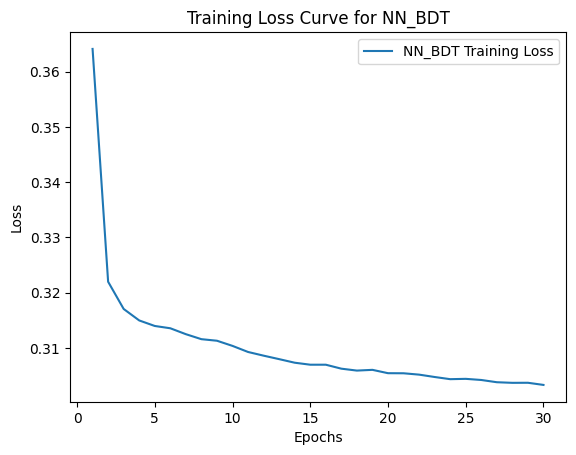

Epoch 1/30, Average Loss: 0.3193
Epoch 2/30, Average Loss: 0.2987
Epoch 3/30, Average Loss: 0.2968
Epoch 4/30, Average Loss: 0.2954
Epoch 5/30, Average Loss: 0.2946
Epoch 6/30, Average Loss: 0.2932
Epoch 7/30, Average Loss: 0.2918
Epoch 8/30, Average Loss: 0.2911
Epoch 9/30, Average Loss: 0.2899
Epoch 10/30, Average Loss: 0.2889
Epoch 11/30, Average Loss: 0.2883
Epoch 12/30, Average Loss: 0.2880
Epoch 13/30, Average Loss: 0.2876
Epoch 14/30, Average Loss: 0.2872
Epoch 15/30, Average Loss: 0.2867
Epoch 16/30, Average Loss: 0.2862
Epoch 17/30, Average Loss: 0.2862
Epoch 18/30, Average Loss: 0.2860
Epoch 19/30, Average Loss: 0.2857
Epoch 20/30, Average Loss: 0.2854
Epoch 21/30, Average Loss: 0.2852
Epoch 22/30, Average Loss: 0.2851
Epoch 23/30, Average Loss: 0.2853
Epoch 24/30, Average Loss: 0.2852
Epoch 25/30, Average Loss: 0.2849
Epoch 26/30, Average Loss: 0.2847
Epoch 27/30, Average Loss: 0.2843
Epoch 28/30, Average Loss: 0.2841
Epoch 29/30, Average Loss: 0.2839
Epoch 30/30, Average Lo

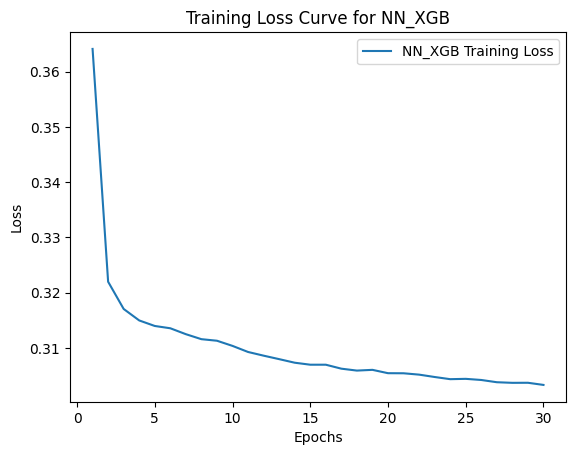

In [15]:
# Convert to PyTorch tensors
X_bdt_train_tensor = torch.tensor(X_nn_bdt_train, dtype=torch.float32)
X_xgb_train_tensor = torch.tensor(X_nn_xgb_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_nn_train, dtype=torch.float32).view(-1, 1)

X_bdt_test_tensor = torch.tensor(X_nn_bdt_test, dtype=torch.float32)
X_xgb_test_tensor = torch.tensor(X_nn_xgb_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_nn_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
bdt_train_loader = DataLoader(TensorDataset(X_bdt_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
xgb_train_loader = DataLoader(TensorDataset(X_xgb_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# Define a simple NN model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize models
nn_bdt = SimpleNN(12)  # 12 BDT features
nn_xgb = SimpleNN(12)  # 12 XGB features

criterion = nn.BCELoss()
optimizer_bdt = optim.Adam(nn_bdt.parameters(), lr=0.001)
optimizer_xgb = optim.Adam(nn_xgb.parameters(), lr=0.001)

loss_history_bdt = []
loss_history_xgb = []

# Train NN_BDT and track loss
print("Training NN_BDT...")
for epoch in range(30):
    total_loss = 0
    num_batches = 0
    
    for batch_X, batch_y in bdt_train_loader:
        optimizer_bdt.zero_grad()
        outputs = nn_bdt(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_bdt.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    loss_history_bdt.append(avg_loss)
    print(f"Epoch {epoch+1}/30, Average Loss: {avg_loss:.4f}")

# Plot loss curve
plt.plot(range(1, 31), loss_history_bdt, label="NN_BDT Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve for NN_BDT")
plt.legend()
plt.show()

# Train NN_XGB
for epoch in range(30):
    total_loss = 0
    num_batches = 0
    
    for batch_X, batch_y in xgb_train_loader:
        optimizer_xgb.zero_grad()
        outputs = nn_xgb(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_xgb.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    loss_history_xgb.append(avg_loss)
    print(f"Epoch {epoch+1}/30, Average Loss: {avg_loss:.4f}")

# Plot loss curve
plt.plot(range(1, 31), loss_history_bdt, label="NN_XGB Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve for NN_XGB")
plt.legend()
plt.show()


In [30]:
# Get predictions
nn_bdt_output = nn_bdt(X_bdt_test_tensor).detach().numpy().flatten()
nn_xgb_output = nn_xgb(X_xgb_test_tensor).detach().numpy().flatten()

# Function to compute signal significance
def compute_significance(threshold, predictions, true_labels):
    S = np.sum((predictions >= threshold) & (true_labels == 1))
    B = np.sum((predictions >= threshold) & (true_labels == 0))
    return S / np.sqrt(S+B) if B > 0 else 0  # Avoid division by zero

def compute_asimov_significance(threshold, predictions, true_labels):
    S = np.sum((predictions >= threshold) & (true_labels == 1))
    B = np.sum((predictions >= threshold) & (true_labels == 0))
    
    if B == 0:
        return np.sqrt(2 * S)  # Asimov approximation when B = 0
    
    return np.sqrt(2 * (S + B * np.log(1 + S / B) - B))

# Sweep through cutoffs
thresholds = np.linspace(0.1, 0.9, 50)

best_threshold_bdt, best_threshold_xgb = 0, 0
best_significance_bdt, best_significance_xgb = 0, 0

best_asimov_threshold_bdt, best_asimov_threshold_xgb = 0, 0
best_asimov_significance_bdt, best_asimov_significance_xgb = 0, 0

for threshold in thresholds:
    # BDT model
    significance_bdt = compute_significance(threshold, nn_bdt_output, y_nn_test)
    asimov_significance_bdt = compute_asimov_significance(threshold, nn_bdt_output, y_nn_test)
    
    if significance_bdt > best_significance_bdt:
        best_significance_bdt = significance_bdt
        best_threshold_bdt = threshold

    if asimov_significance_bdt > best_asimov_significance_bdt:
        best_asimov_significance_bdt = asimov_significance_bdt
        best_asimov_threshold_bdt = threshold

    # XGB model
    significance_xgb = compute_significance(threshold, nn_xgb_output, y_nn_test)
    asimov_significance_xgb = compute_asimov_significance(threshold, nn_xgb_output, y_nn_test)
    
    if significance_xgb > best_significance_xgb:
        best_significance_xgb = significance_xgb
        best_threshold_xgb = threshold

    if asimov_significance_xgb > best_asimov_significance_xgb:
        best_asimov_significance_xgb = asimov_significance_xgb
        best_asimov_threshold_xgb = threshold

print(f"NN_BDT: Best Threshold = {best_threshold_bdt:.2f}, Max Significance = {best_significance_bdt:.2f}")
print(f"NN_XGB: Best Threshold = {best_threshold_xgb:.2f}, Max Significance = {best_significance_xgb:.2f}")

print(f"NN_BDT: Best Threshold (Asimov) = {best_asimov_threshold_bdt:.2f}, Max Significance = {best_asimov_significance_bdt:.2f}")
print(f"NN_XGB: Best Threshold (Asimov) = {best_asimov_threshold_xgb:.2f}, Max Significance = {best_asimov_significance_xgb:.2f}")

NN_BDT: Best Threshold = 0.39, Max Significance = 165.67
NN_XGB: Best Threshold = 0.28, Max Significance = 171.19
NN_BDT: Best Threshold (Asimov) = 0.38, Max Significance = 294.63
NN_XGB: Best Threshold (Asimov) = 0.26, Max Significance = 304.08


(array([97552., 19681., 12441., 10395.,  9001.,  7638.,  6238.,  5288.,
         4832.,  4469.,  4123.,  3678.,  3275.,  3021.,  2796.,  2703.,
         2611.,  2436.,  2265.,  2084.,  2013.,  1912.,  1755.,  1631.,
         1536.,  1498.,  1494.,  1362.,  1288.,  1258.,  1104.,  1001.,
          800.,   756.,   714.,   704.,   764.,   751.,   786.,   843.,
          910.,   964.,  1135.,  1189.,  1401.,  1744.,  2202.,  2814.,
         3889., 10962.]),
 array([1.32471200e-06, 1.97056606e-02, 3.94099988e-02, 5.91143370e-02,
        7.88186714e-02, 9.85230058e-02, 1.18227348e-01, 1.37931675e-01,
        1.57636017e-01, 1.77340358e-01, 1.97044685e-01, 2.16749027e-01,
        2.36453369e-01, 2.56157696e-01, 2.75862008e-01, 2.95566350e-01,
        3.15270692e-01, 3.34975034e-01, 3.54679376e-01, 3.74383688e-01,
        3.94088030e-01, 4.13792372e-01, 4.33496714e-01, 4.53201056e-01,
        4.72905397e-01, 4.92609710e-01, 5.12314081e-01, 5.32018363e-01,
        5.51722705e-01, 5.71427047e-01

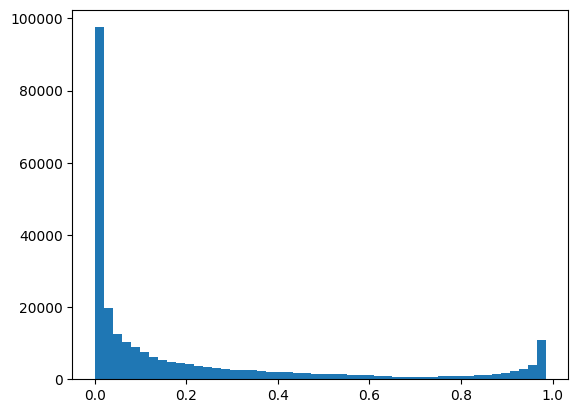

In [23]:
plt.hist(nn_xgb_output, bins=50)

In [27]:
# Get training set performance
train_preds_bdt = nn_bdt(X_bdt_train_tensor).detach().numpy().flatten()
train_preds_xgb = nn_xgb(X_xgb_train_tensor).detach().numpy().flatten()

train_acc_bdt = np.mean((train_preds_bdt > 0.5) == y_nn_train)
train_acc_xgb = np.mean((train_preds_xgb > 0.5) == y_nn_train)

test_acc_bdt = np.mean((nn_bdt_output > 0.5) == y_nn_test)
test_acc_xgb = np.mean((nn_xgb_output > 0.5) == y_nn_test)

print(f"NN_BDT Train Accuracy: {train_acc_bdt:.4f}, Test Accuracy: {test_acc_bdt:.4f}")
print(f"NN_XGB Train Accuracy: {train_acc_xgb:.4f}, Test Accuracy: {test_acc_xgb:.4f}")


NN_BDT Train Accuracy: 0.8670, Test Accuracy: 0.8671
NN_XGB Train Accuracy: 0.8754, Test Accuracy: 0.8751


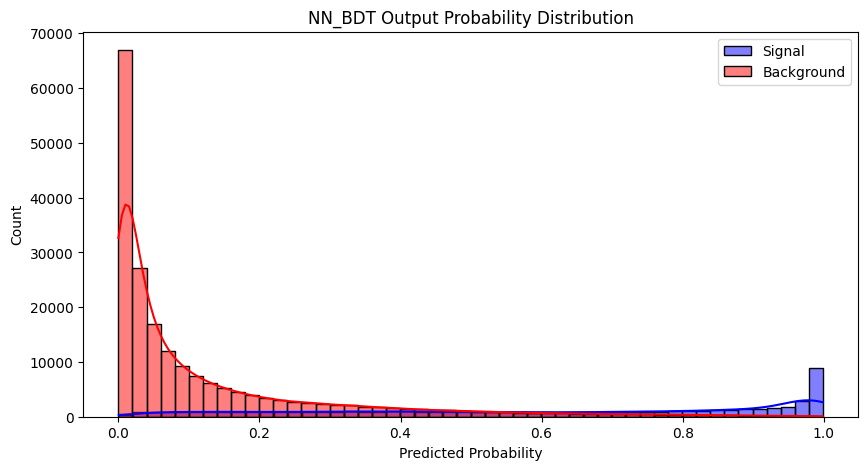

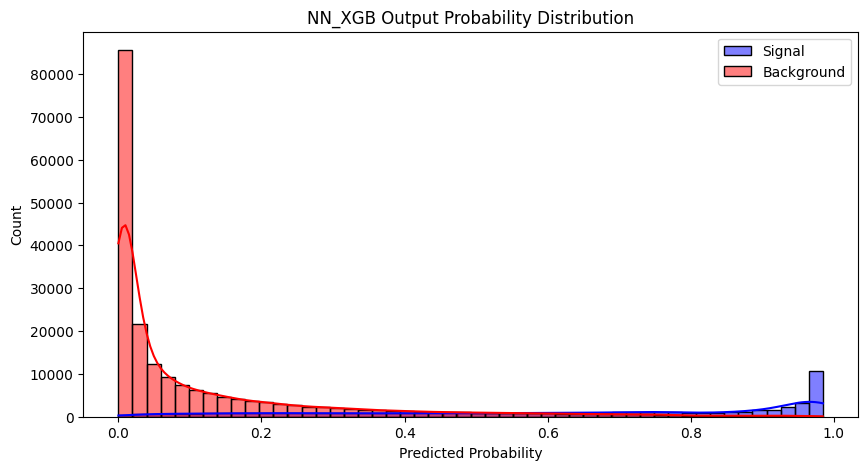

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of NN outputs for signal and background
plt.figure(figsize=(10,5))
sns.histplot(nn_bdt_output[y_nn_test == 1], bins=50, color='blue', label="Signal", kde=True)
sns.histplot(nn_bdt_output[y_nn_test == 0], bins=50, color='red', label="Background", kde=True)
plt.title("NN_BDT Output Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Plot distribution of NN outputs for signal and background
plt.figure(figsize=(10,5))
sns.histplot(nn_xgb_output[y_nn_test == 1], bins=50, color='blue', label="Signal", kde=True)
sns.histplot(nn_xgb_output[y_nn_test == 0], bins=50, color='red', label="Background", kde=True)
plt.title("NN_XGB Output Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()
